# The influence of weather on bike-sharing
## Sources of datasets:

[London weather data](https://www.kaggle.com/datasets/noahx1/london-weather-2000-2023)

[Bike-Share Usage in London and Taipei Network](https://www.kaggle.com/datasets/ajohrn/bikeshare-usage-in-london-and-taipei-network/data)

### Things to do to run:
* Download these three datasets: London.csv, London_stations.csv (source 2) & london0_23_weather_data.csv (source 1)
* Place the files together with this code in a shared folder

To run the code (in VSC):
* Make sure you have Python installed (I'm using Python 3.11.9)
* To the upper right here, select this Python as kernel
* It migh be that you still need to select an environment to run the code, use .venv
* In the cell below: uncomment the pip-commands (only run this once, then comment them again)
* It should work now :)

## Installing and defining names and files

In [ ]:
#pip install seaborn

In [ ]:
#pip install pandas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
#We only look at the London-data (there is also data from Taipei network)
df_london = pd.read_csv('london.csv', parse_dates=[3,6], infer_datetime_format=True)
df_london.shape
df_london.head(3)

C:\Users\arthu\AppData\Local\Temp\ipykernel_47260\2391621177.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_london = pd.read_csv('london.csv', parse_dates=[3,6], infer_datetime_format=True)


(38215560, 9)

In [3]:
#import the names of the stations (a bit easier to identify stations later)
df_london_geo = pd.read_csv('london_stations.csv')
df_london_geo.head(3)

,station_id,station_name,longitude,latitude
0,1,"River Street, Clerkenwell",-0.109971,51.5292
1,2,"Phillimore Gardens, Kensington",-0.197574,51.4996
2,3,"Christopher Street, Liverpool Street",-0.084606,51.5213


In [ ]:
#import weather data of London (this goes from 2000-2023, so we can discard a lot later) #The dates should still be added: start at 01/01/2000-01/01/2023
df_london_weather = pd.read_csv('london0_23_weather_data.csv')
df_london_weather.head(3)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,7.3,3.1,9.0,1.8,NaN,NaN,2.3,NaN,1024.5,NaN
1,9.5,8.0,11.0,NaN,NaN,225.0,11.6,NaN,1025.2,NaN
2,9.4,5.6,11.2,2.0,NaN,233.0,16.8,NaN,1018.5,NaN


In [5]:
#The data includes rare rental events that are started but not ended. For this analysis these are best removed.
df_london = df_london.loc[~df_london.isnull().any(axis=1)]
df_london = df_london.astype({'bike_id' : 'int32', 'end_station_id' : 'int32', 'start_station_id' : 'int32'})
df_london.shape

(38147278, 9)

In [6]:
#Augment datetime data to make it easier for binning and applying conditions with respect to time.
df_london.loc[:, 'year'] = df_london['start_rental_date_time'].dt.year
df_london.loc[:, 'month'] = df_london['start_rental_date_time'].dt.month
df_london.loc[:, 'week'] = df_london['start_rental_date_time'].dt.isocalendar().week
df_london.loc[:, 'day'] = df_london['start_rental_date_time'].dt.day
df_london.loc[:, 'hour'] = df_london['start_rental_date_time'].dt.hour
df_london.loc[:, 'dayofweek'] = df_london['start_rental_date_time'].dt.dayofweek
df_london.loc[:, 'satsun'] = df_london['dayofweek'].map({0: False, 1: False, 2: False, 3: False, 4: False, 5: True, 6:True})
df_london.shape

(38147278, 16)

In [7]:
#A handful of stations are very rarely part of any rental events. 
#In some cases these are temporary stations or stations that become decommissioned. 
#In some analysis these low count stations are best removed.

below_or_above_stations = df_london['start_station_name'].value_counts() < 500
low_stations = below_or_above_stations.loc[below_or_above_stations].index
df_london = df_london.loc[~df_london['start_station_name'].isin(low_stations)]
df_london = df_london.loc[~df_london['end_station_name'].isin(low_stations)]
df_london.shape

(38144414, 16)

<Axes: xlabel='month', ylabel='rental_id'>

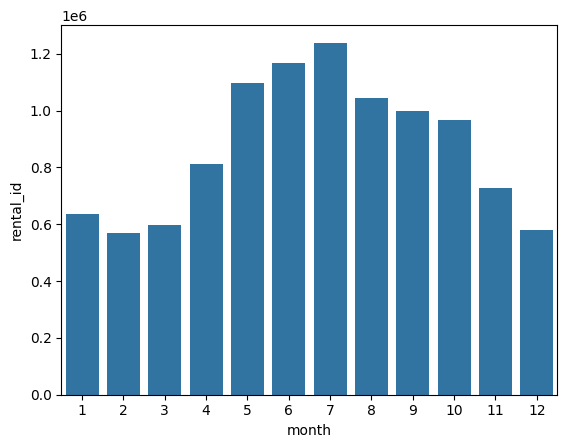

In [8]:
#small test: the number of rental events in the months of a particular year, say 2018
per_month_2018_group = df_london.loc[df_london['year'] == 2018].groupby('month')
month_counts = per_month_2018_group.count()

sns.barplot(x=month_counts.index, y=month_counts.iloc[:,0])

<Axes: xlabel='hour'>

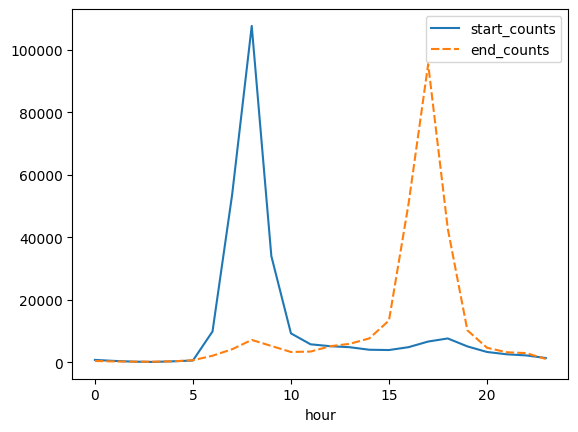

In [9]:
weekday_14_start = df_london.loc[(df_london['start_station_id'] == 14) & (df_london['satsun'] == False)]
weekday_14_end = df_london.loc[(df_london['end_station_id'] == 14) & (df_london['satsun'] == False)]
weekday_14_start = weekday_14_start.groupby('hour').count()
weekday_14_end = weekday_14_end.groupby('hour').count()
weekday_14_data = pd.DataFrame({'start_counts' : weekday_14_start.iloc[:,0],
                                'end_counts' : weekday_14_end.iloc[:,0]})

sns.lineplot(data=weekday_14_data)

## The analysis